# Teeth Classification Pipeline
## Preprocessing, Visualization, and Model Training

**Objective:** Develop a comprehensive teeth classification solution for 7 distinct categories

**Pipeline Components:**
1. Data Loading and Exploration
2. Preprocessing and Augmentation
3. Visualization and Analysis
4. Model Architecture and Training
5. Evaluation and Results

---

## 1. Setup and Configuration

In [22]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Computer Vision
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuration
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Teeth DataSet.zip'
extracted_root_path = '/content/Teeth_Dataset'  # Destination for extracted files

# Check if the dataset is already unzipped
if not os.path.exists(extracted_root_path):
    print(f"Extracting {zip_file_path} to {extracted_root_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_root_path)
    print("Extraction complete.")
else:
    print(f"Dataset already extracted to {extracted_root_path}.")

# Update dataset_path to point to the correct nested directory
dataset_path = os.path.join(extracted_root_path, 'Teeth_Dataset')

train_path = os.path.join(dataset_path, 'Training')
test_path = os.path.join(dataset_path, 'Testing')
val_path = os.path.join(dataset_path, 'Validation')  # Added validation path

# Get categories
categories = sorted([d for d in os.listdir(train_path)
                    if os.path.isdir(os.path.join(train_path, d))
                    and not d.startswith('out')])  # Exclude output folders

Dataset already extracted to /content/Teeth_Dataset.


In [25]:
# Project Configuration
class Config:
    """Central configuration for the teeth classification pipeline"""

    # Data paths
    DATA_DIR = '/content/teeth_dataset'  # Update with your path

    # Image parameters
    IMG_HEIGHT = 256
    IMG_WIDTH = 256
    IMG_CHANNELS = 3
    IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.01
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1

    # Model parameters
    NUM_CLASSES = 7

    # Class names (update based on your dataset)
    CLASS_NAMES = [
        'Incisor', 'Canine', 'Premolar', 'Molar',
        'Wisdom', 'Damaged', 'Healthy'
    ]

config = Config()
print("Configuration loaded successfully")

Configuration loaded successfully


## 2. Data Loading and Exploration

In [26]:
def load_dataset(data_dir, split_name):
    """
    Load dataset and create a structured DataFrame for a given split.

    Args:
        data_dir: Path to dataset directory for a specific split (e.g., Training, Testing, Validation)
        split_name: Name of the split (e.g., 'train', 'test', 'val')

    Returns:
        DataFrame with image paths, labels, and split information
    """
    data = []

    # Ensure data_dir exists before proceeding
    if not os.path.isdir(data_dir):
        print(f"Warning: Directory not found: {data_dir}")
        return pd.DataFrame()

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                data.append({
                    'image_path': img_path,
                    'class': class_name,
                    'filename': img_name,
                    'split': split_name
                })

    df = pd.DataFrame(data)
    return df

# Load data for each split separately
# Use the paths defined in the notebook state (train_path, test_path, val_path)
train_df_raw = load_dataset(train_path, 'train')
val_df_raw = load_dataset(val_path, 'val')
test_df_raw = load_dataset(test_path, 'test')

# Concatenate all dataframes
df = pd.concat([train_df_raw, val_df_raw, test_df_raw], ignore_index=True)

# Define the classes to be removed (based on user's implicit request and observed data)
classes_to_remove = ['out', 'output', 'outputs'] # These are the extra classes causing 10 vs 7 mismatch

# Filter out the unwanted classes from the DataFrame
df = df[~df['class'].isin(classes_to_remove)].reset_index(drop=True)

# Add encoded labels to the combined DataFrame
if not df.empty:
    df['label'] = pd.Categorical(df['class']).codes

# Update Config with actual number of classes and class names from the filtered DataFrame
config.NUM_CLASSES = df['class'].nunique()
config.CLASS_NAMES = sorted(df['class'].unique().tolist())

print(f"Total images: {len(df)}")
print(f"\nClass distribution:\n{df['class'].value_counts()}")
print(f"\nDataset shape: {df.shape}")
print(f"\nSplit distribution:\n{df['split'].value_counts()}")
print(f"\nUpdated config.NUM_CLASSES: {config.NUM_CLASSES}")
print(f"\nUpdated config.CLASS_NAMES: {config.CLASS_NAMES}")
df.head()

Total images: 5143

Class distribution:
class
OLP    900
MC     900
CaS    800
CoS    748
OT     655
Gum    600
OC     540
Name: count, dtype: int64

Dataset shape: (5143, 5)

Split distribution:
split
train    3087
val      1028
test     1028
Name: count, dtype: int64

Updated config.NUM_CLASSES: 7

Updated config.CLASS_NAMES: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


image_path class           filename  \
0  /content/Teeth_Dataset/Teeth_Dataset/Training/...   OLP   p_1226_0_103.jpg   
1  /content/Teeth_Dataset/Teeth_Dataset/Training/...   OLP  p_1223_0_1842.jpg   
2  /content/Teeth_Dataset/Teeth_Dataset/Training/...   OLP  p_1285_0_3161.jpg   
3  /content/Teeth_Dataset/Teeth_Dataset/Training/...   OLP  p_1243_0_9283.jpg   
4  /content/Teeth_Dataset/Teeth_Dataset/Training/...   OLP         p_1210.jpg   

   split  label  
0  train      5  
1  train      5  
2  train      5  
3  train      5  
4  train      5

In [27]:
# Dataset statistics
def get_dataset_stats(df):
    """Generate comprehensive dataset statistics"""

    stats = {
        'Total Images': len(df),
        'Number of Classes': df['class'].nunique(),
        'Min Images per Class': df['class'].value_counts().min(),
        'Max Images per Class': df['class'].value_counts().max(),
        'Average Images per Class': df['class'].value_counts().mean(),
        'Class Imbalance Ratio': df['class'].value_counts().max() / df['class'].value_counts().min()
    }

    return pd.Series(stats)

stats = get_dataset_stats(df)
print("\nDataset Statistics:")
print("="*50)
print(stats)


Dataset Statistics:
Total Images                5143.000000
Number of Classes              7.000000
Min Images per Class         540.000000
Max Images per Class         900.000000
Average Images per Class     734.714286
Class Imbalance Ratio          1.666667
dtype: float64


## 3. Visualization - Class Distribution

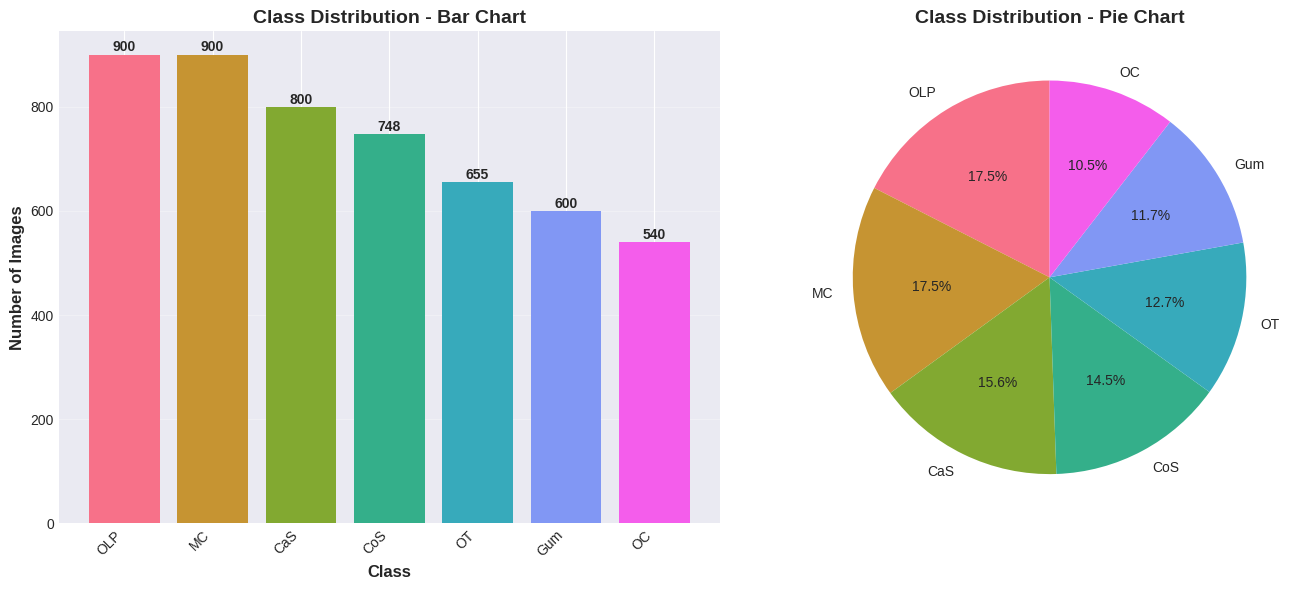


Detailed Class Distribution:
Class  Count  Percentage
  OLP    900       17.50
   MC    900       17.50
  CaS    800       15.56
  CoS    748       14.54
   OT    655       12.74
  Gum    600       11.67
   OC    540       10.50


In [48]:
def plot_class_distribution(df, figsize=(14, 6)):
    """
    Visualize class distribution with bar plot and pie chart
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Bar plot
    class_counts = df['class'].value_counts()
    axes[0].bar(range(len(class_counts)), class_counts.values, color=sns.color_palette('husl', len(class_counts)))
    axes[0].set_xticks(range(len(class_counts)))
    axes[0].set_xticklabels(class_counts.index, rotation=45, ha='right')
    axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    axes[0].set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(class_counts.values):
        axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

    # Pie chart
    axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette('husl', len(class_counts)))
    axes[1].set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print distribution table
    print("\nDetailed Class Distribution:")
    print("="*60)
    dist_df = pd.DataFrame({
        'Class': class_counts.index,
        'Count': class_counts.values,
        'Percentage': (class_counts.values / len(df) * 100).round(2)
    })
    print(dist_df.to_string(index=False))

plot_class_distribution(df)

## 4. Sample Images Visualization

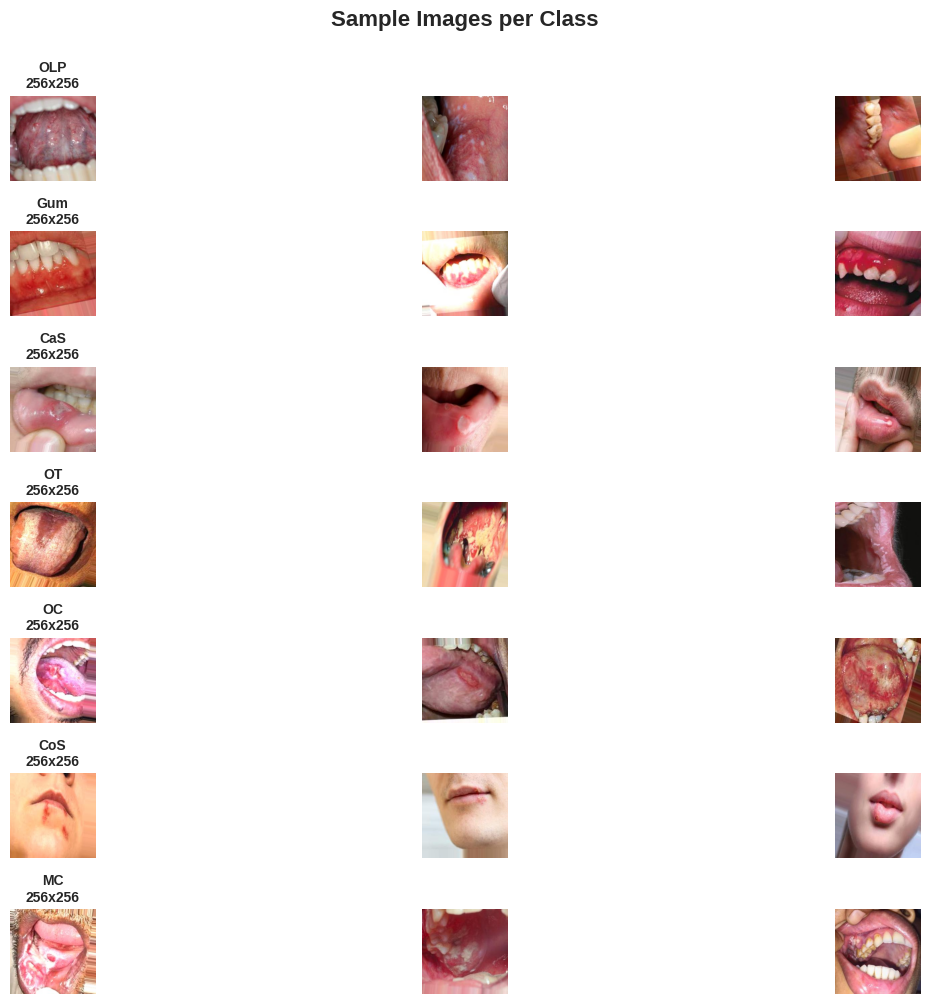

In [46]:
def display_sample_images(df, samples_per_class=3, figsize=(15, 10)):
    """
    Display sample images from each class
    """
    classes = df['class'].unique()
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)

    for i, class_name in enumerate(classes):
        class_df = df[df['class'] == class_name]
        samples = class_df.sample(min(samples_per_class, len(class_df)))

        for j, (_, row) in enumerate(samples.iterrows()):
            img = cv2.imread(row['image_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax = axes[i, j] if n_classes > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')

            if j == 0:
                ax.set_title(f'{class_name}\n{img.shape[0]}x{img.shape[1]}',
                           fontsize=10, fontweight='bold')

    plt.suptitle('Sample Images per Class', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

display_sample_images(df)

## 5. Data Preprocessing Pipeline

In [30]:
def create_augmentation_pipeline():
    """
    Create image augmentation pipeline for training data
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Validation/Test data - only rescaling
    val_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, val_datagen

train_datagen, val_datagen = create_augmentation_pipeline()
print("Augmentation pipeline created successfully")

Augmentation pipeline created successfully


## 6. Before/After Augmentation Visualization

Augmentation Examples:

Example 1:


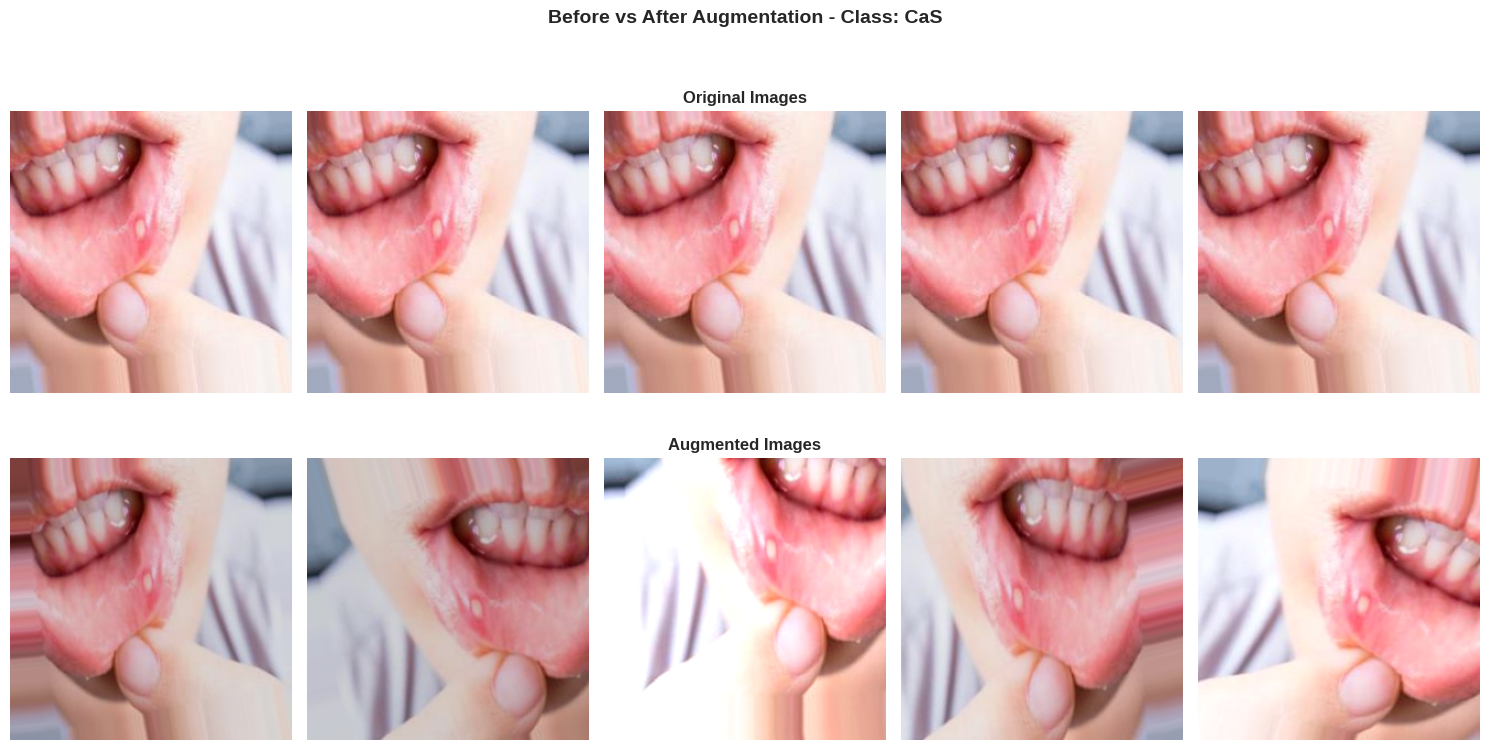


Example 2:


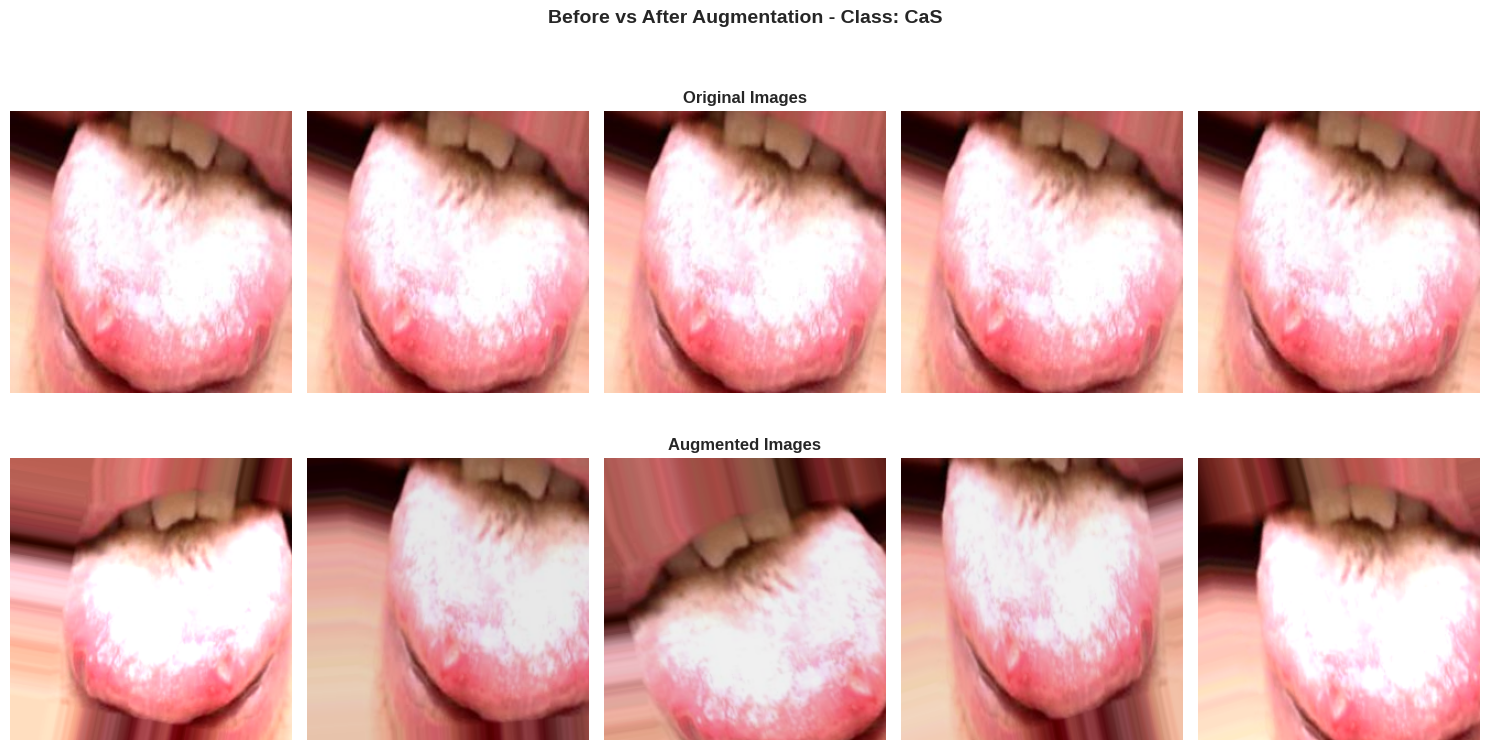


Example 3:


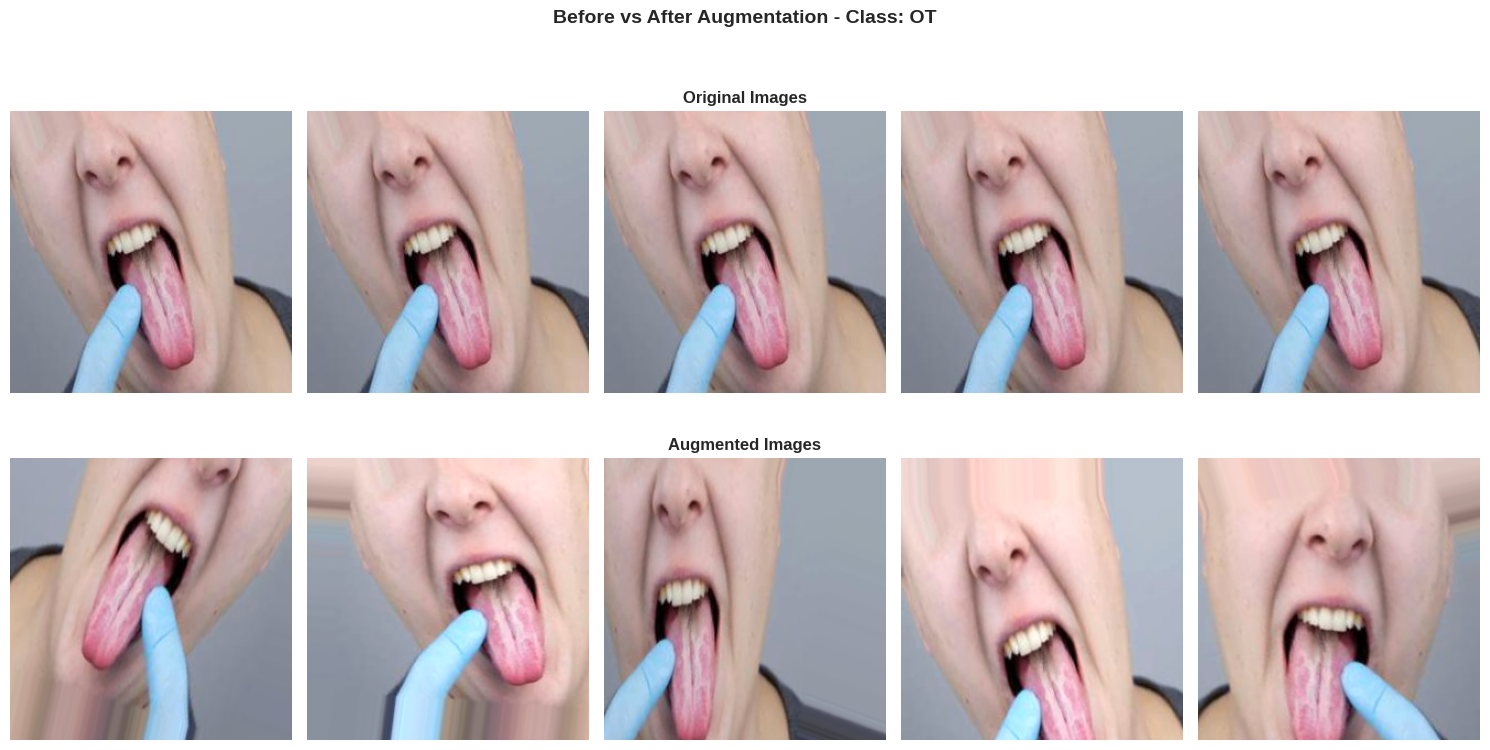

In [31]:
def visualize_augmentation(df, n_augmentations=5, figsize=(15, 8)):
    """
    Display original image and its augmented versions
    """
    # Select a random image
    sample = df.sample(1).iloc[0]
    img_path = sample['image_path']
    class_name = sample['class']

    # Load and preprocess image
    img = load_img(img_path, target_size=config.IMG_SIZE)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Create figure
    fig, axes = plt.subplots(2, n_augmentations, figsize=figsize)

    # Original images
    for i in range(n_augmentations):
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == n_augmentations // 2:
            axes[0, i].set_title('Original Images', fontsize=12, fontweight='bold')

    # Augmented images
    aug_iter = train_datagen.flow(img_array, batch_size=1)

    for i in range(n_augmentations):
        aug_img = next(aug_iter)[0]
        axes[1, i].imshow(aug_img)
        axes[1, i].axis('off')
        if i == n_augmentations // 2:
            axes[1, i].set_title('Augmented Images', fontsize=12, fontweight='bold')

    plt.suptitle(f'Before vs After Augmentation - Class: {class_name}',
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Visualize augmentation multiple times to see variety
print("Augmentation Examples:")
print("="*60)
for i in range(3):
    print(f"\nExample {i+1}:")
    visualize_augmentation(df)

## 7. Data Splitting and Preparation

In [47]:
# Split dataset
train_df, temp_df = train_test_split(
    df,
    test_size=(config.VALIDATION_SPLIT + config.TEST_SPLIT),
    stratify=df['class'],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=config.TEST_SPLIT/(config.VALIDATION_SPLIT + config.TEST_SPLIT),
    stratify=temp_df['class'],
    random_state=SEED
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df)}")

# Verify stratification
print("\nClass distribution in splits:")
split_dist = pd.DataFrame({
    'Train': train_df['class'].value_counts().sort_index(),
    'Val': val_df['class'].value_counts().sort_index(),
    'Test': test_df['class'].value_counts().sort_index()
}).fillna(0).astype(int)
print(split_dist)

Training samples: 3600
Validation samples: 1028
Test samples: 515

Total: 5143

Class distribution in splits:
       Train  Val  Test
class                  
CaS      560  160    80
CoS      524  149    75
Gum      420  120    60
MC       630  180    90
OC       378  108    54
OLP      630  180    90
OT       458  131    66


In [33]:
def create_data_generators(train_df, val_df, test_df, train_datagen, val_datagen):
    """
    Create data generators from dataframes
    """
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='class',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='class',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='class',
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = create_data_generators(
    train_df, val_df, test_df, train_datagen, val_datagen
)

print("Data generators created successfully")
print(f"\nClass indices: {train_gen.class_indices}")

Found 3600 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.
Found 515 validated image filenames belonging to 7 classes.
Data generators created successfully

Class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


## 8. Model Architecture

In [34]:
def build_custom_cnn(input_shape, num_classes):
    """
    Build a custom CNN architecture for teeth classification

    Architecture:
    - 4 Convolutional blocks with increasing filters
    - Batch Normalization for stable training
    - MaxPooling for dimensionality reduction
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
model = build_custom_cnn(
    input_shape=(config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS),
    num_classes=config.NUM_CLASSES
)

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,443,879 (5.51 MB)

 Trainable params: 1,440,423 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [35]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print("Model compiled successfully")
print(f"\nOptimizer: Adam (lr={config.LEARNING_RATE})")
print(f"Loss: Categorical Crossentropy")
print(f"Metrics: Accuracy, Top-3 Accuracy")

Model compiled successfully

Optimizer: Adam (lr=0.01)
Loss: Categorical Crossentropy
Metrics: Accuracy, Top-3 Accuracy


## 9. Training Callbacks

In [36]:
# Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_teeth_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early Stopping (patience=10)")
print("- Learning Rate Reduction (patience=5, factor=0.5)")
print("- Model Checkpoint (save best model)")

Callbacks configured:
- Early Stopping (patience=10)
- Learning Rate Reduction (patience=5, factor=0.5)
- Model Checkpoint (save best model)


## 10. Model Training

In [37]:
# Calculate steps
steps_per_epoch = len(train_df) // config.BATCH_SIZE
validation_steps = len(val_df) // config.BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"\nStarting training for {config.EPOCHS} epochs...\n")

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=config.EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Steps per epoch: 112
Validation steps: 32

Starting training for 50 epochs...

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.1885 - loss: 2.6865 - top_3_accuracy: 0.5176
Epoch 1: val_accuracy improved from -inf to 0.18945, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 902ms/step - accuracy: 0.1886 - loss: 2.6839 - top_3_accuracy: 0.5177 - val_accuracy: 0.1895 - val_loss: 26.8968 - val_top_3_accuracy: 0.4375 - learning_rate: 0.0100
Epoch 2/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.1562 - loss: 2.2760 - top_3_accuracy: 0.4062
Epoch 2: val_accuracy improved from 0.18945 to 0.19336, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1562 - loss: 2.2760 - top_3_accuracy: 0.4062 - val_accuracy: 0.1934 - val_loss: 21.7599 - val_top_3_accuracy: 0.4375 - learning_rate: 0.0100
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.2510 - loss: 2.0321 - top_3_accuracy: 0.5899
Epoch 3: val_accuracy improved from 0.19336 to 0.24512, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 632ms/step - accuracy: 0.2511 - loss: 2.0314 - top_3_accuracy: 0.5901 - val_accuracy: 0.2451 - val_loss: 3.7823 - val_top_3_accuracy: 0.5039 - learning_rate: 0.0100
Epoch 4/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.2500 - loss: 2.0153 - top_3_accuracy: 0.5625
Epoch 4: val_accuracy improved from 0.24512 to 0.24805, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2500 - loss: 2.0153 - top_3_accuracy: 0.5625 - val_accuracy: 0.2480 - val_loss: 3.8863 - val_top_3_accuracy: 0.4951 - learning_rate: 0.0100
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.2813 - loss: 1.8793 - top_3_accuracy: 0.6245
Epoch 5: val_accuracy improved from 0.24805 to 0.27148, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 638ms/step - accuracy: 0.2813 - loss: 1.8791 - top_3_accuracy: 0.6246 - val_accuracy: 0.2715 - val_loss: 2.1281 - val_top_3_accuracy: 0.6006 - learning_rate: 0.0100
Epoch 6/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.2500 - loss: 1.6759 - top_3_accuracy: 0.7188
Epoch 6: val_accuracy did not improve from 0.27148
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.6759 - top_3_accuracy: 0.7188 - val_accuracy: 0.2686 - val_loss: 2.1331 - val_top_3_accuracy: 0.5918 - learning_rate: 0.0100
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.3165 - loss: 1.7247 - top_3_accuracy: 0.6801
Epoch 7: val_accuracy did not improve from 0.27148
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 626ms/step - accuracy: 0.3165 - loss: 1.7249 - top_3_accuracy: 0.6800 - val_accuracy: 0.1680 - val_loss: 2.6632 - val_top_3_accuracy: 0.5078 - learning_rate: 0.0100
Epoch 8/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.2812 - los

112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 627ms/step - accuracy: 0.3565 - loss: 1.6354 - top_3_accuracy: 0.7161 - val_accuracy: 0.2773 - val_loss: 2.2103 - val_top_3_accuracy: 0.5762 - learning_rate: 0.0050
Epoch 12/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.4375 - loss: 1.6817 - top_3_accuracy: 0.8438
Epoch 12: val_accuracy improved from 0.27734 to 0.28027, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4375 - loss: 1.6817 - top_3_accuracy: 0.8438 - val_accuracy: 0.2803 - val_loss: 2.1575 - val_top_3_accuracy: 0.5801 - learning_rate: 0.0050
Epoch 13/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3934 - loss: 1.5697 - top_3_accuracy: 0.7387
Epoch 13: val_accuracy improved from 0.28027 to 0.42383, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 641ms/step - accuracy: 0.3934 - loss: 1.5697 - top_3_accuracy: 0.7388 - val_accuracy: 0.4238 - val_loss: 1.4858 - val_top_3_accuracy: 0.7832 - learning_rate: 0.0050
Epoch 14/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.2500 - loss: 1.7307 - top_3_accuracy: 0.6562
Epoch 14: val_accuracy did not improve from 0.42383
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.7307 - top_3_accuracy: 0.6562 - val_accuracy: 0.4150 - val_loss: 1.4885 - val_top_3_accuracy: 0.7812 - learning_rate: 0.0050
Epoch 15/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4023 - loss: 1.5361 - top_3_accuracy: 0.7497
Epoch 15: val_accuracy did not improve from 0.42383
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 626ms/step - accuracy: 0.4023 - loss: 1.5360 - top_3_accuracy: 0.7498 - val_accuracy: 0.3701 - val_loss: 1.6800 - val_top_3_accuracy: 0.7490 - learning_rate: 0.0050
Epoch 16/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.4062 

112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 627ms/step - accuracy: 0.4535 - loss: 1.4096 - top_3_accuracy: 0.8080 - val_accuracy: 0.4824 - val_loss: 1.3683 - val_top_3_accuracy: 0.8203 - learning_rate: 0.0025
Epoch 20/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.5000 - loss: 1.3657 - top_3_accuracy: 0.8125
Epoch 20: val_accuracy did not improve from 0.48242
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5000 - loss: 1.3657 - top_3_accuracy: 0.8125 - val_accuracy: 0.4775 - val_loss: 1.3801 - val_top_3_accuracy: 0.8154 - learning_rate: 0.0025
Epoch 21/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4764 - loss: 1.3513 - top_3_accuracy: 0.8135
Epoch 21: val_accuracy improved from 0.48242 to 0.50781, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 637ms/step - accuracy: 0.4763 - loss: 1.3515 - top_3_accuracy: 0.8135 - val_accuracy: 0.5078 - val_loss: 1.2747 - val_top_3_accuracy: 0.8350 - learning_rate: 0.0025
Epoch 22/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.5625 - loss: 1.2333 - top_3_accuracy: 0.9688
Epoch 22: val_accuracy improved from 0.50781 to 0.51367, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5625 - loss: 1.2333 - top_3_accuracy: 0.9688 - val_accuracy: 0.5137 - val_loss: 1.2792 - val_top_3_accuracy: 0.8350 - learning_rate: 0.0025
Epoch 23/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4681 - loss: 1.3453 - top_3_accuracy: 0.8390
Epoch 23: val_accuracy improved from 0.51367 to 0.51855, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 633ms/step - accuracy: 0.4681 - loss: 1.3453 - top_3_accuracy: 0.8389 - val_accuracy: 0.5186 - val_loss: 1.2210 - val_top_3_accuracy: 0.8701 - learning_rate: 0.0025
Epoch 24/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.5312 - loss: 1.2311 - top_3_accuracy: 0.8125
Epoch 24: val_accuracy improved from 0.51855 to 0.53613, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5312 - loss: 1.2311 - top_3_accuracy: 0.8125 - val_accuracy: 0.5361 - val_loss: 1.2190 - val_top_3_accuracy: 0.8643 - learning_rate: 0.0025
Epoch 25/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5050 - loss: 1.3194 - top_3_accuracy: 0.8392
Epoch 25: val_accuracy did not improve from 0.53613
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 621ms/step - accuracy: 0.5049 - loss: 1.3194 - top_3_accuracy: 0.8393 - val_accuracy: 0.5254 - val_loss: 1.2570 - val_top_3_accuracy: 0.8564 - learning_rate: 0.0025
Epoch 26/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.4688 - loss: 1.2374 - top_3_accuracy: 0.8750
Epoch 26: val_accuracy did not improve from 0.53613
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4688 - loss: 1.2374 - top_3_accuracy: 0.8750 - val_accuracy: 0.5215 - val_loss: 1.2648 - val_top_3_accuracy: 0.8516 - learning_rate: 0.0025
Epoch 27/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.5111 - l

112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 625ms/step - accuracy: 0.5523 - loss: 1.1735 - top_3_accuracy: 0.8823 - val_accuracy: 0.5898 - val_loss: 1.0388 - val_top_3_accuracy: 0.9072 - learning_rate: 0.0012
Epoch 32/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.5312 - loss: 1.2416 - top_3_accuracy: 0.8438
Epoch 32: val_accuracy improved from 0.58984 to 0.59766, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5312 - loss: 1.2416 - top_3_accuracy: 0.8438 - val_accuracy: 0.5977 - val_loss: 1.0169 - val_top_3_accuracy: 0.9111 - learning_rate: 0.0012
Epoch 33/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.5852 - loss: 1.0969 - top_3_accuracy: 0.8962
Epoch 33: val_accuracy did not improve from 0.59766
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 622ms/step - accuracy: 0.5851 - loss: 1.0970 - top_3_accuracy: 0.8962 - val_accuracy: 0.5156 - val_loss: 1.2718 - val_top_3_accuracy: 0.8447 - learning_rate: 0.0012
Epoch 34/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.6250 - loss: 1.1491 - top_3_accuracy: 0.8438
Epoch 34: val_accuracy did not improve from 0.59766
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6250 - loss: 1.1491 - top_3_accuracy: 0.8438 - val_accuracy: 0.5293 - val_loss: 1.2337 - val_top_3_accuracy: 0.8594 - learning_rate: 0.0012
Epoch 35/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.5685 - l

112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 635ms/step - accuracy: 0.5686 - loss: 1.1243 - top_3_accuracy: 0.8944 - val_accuracy: 0.6006 - val_loss: 1.0090 - val_top_3_accuracy: 0.9053 - learning_rate: 0.0012
Epoch 36/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.6250 - loss: 1.2020 - top_3_accuracy: 0.8125
Epoch 36: val_accuracy did not improve from 0.60059
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6250 - loss: 1.2020 - top_3_accuracy: 0.8125 - val_accuracy: 0.5996 - val_loss: 1.0104 - val_top_3_accuracy: 0.9053 - learning_rate: 0.0012
Epoch 37/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6049 - loss: 1.0478 - top_3_accuracy: 0.9067
Epoch 37: val_accuracy improved from 0.60059 to 0.60840, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 622ms/step - accuracy: 0.6049 - loss: 1.0478 - top_3_accuracy: 0.9067 - val_accuracy: 0.6084 - val_loss: 0.9921 - val_top_3_accuracy: 0.9043 - learning_rate: 0.0012
Epoch 38/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.5938 - loss: 0.9871 - top_3_accuracy: 0.9062
Epoch 38: val_accuracy did not improve from 0.60840
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5938 - loss: 0.9871 - top_3_accuracy: 0.9062 - val_accuracy: 0.6045 - val_loss: 0.9939 - val_top_3_accuracy: 0.9092 - learning_rate: 0.0012
Epoch 39/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6214 - loss: 1.0033 - top_3_accuracy: 0.9169
Epoch 39: val_accuracy improved from 0.60840 to 0.62695, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 635ms/step - accuracy: 0.6213 - loss: 1.0035 - top_3_accuracy: 0.9168 - val_accuracy: 0.6270 - val_loss: 1.0735 - val_top_3_accuracy: 0.9385 - learning_rate: 0.0012
Epoch 40/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.6250 - loss: 1.1058 - top_3_accuracy: 0.8750
Epoch 40: val_accuracy improved from 0.62695 to 0.62988, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6250 - loss: 1.1058 - top_3_accuracy: 0.8750 - val_accuracy: 0.6299 - val_loss: 1.0552 - val_top_3_accuracy: 0.9443 - learning_rate: 0.0012
Epoch 41/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6254 - loss: 1.0052 - top_3_accuracy: 0.9174
Epoch 41: val_accuracy improved from 0.62988 to 0.65234, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 627ms/step - accuracy: 0.6254 - loss: 1.0052 - top_3_accuracy: 0.9173 - val_accuracy: 0.6523 - val_loss: 0.9391 - val_top_3_accuracy: 0.9258 - learning_rate: 0.0012
Epoch 42/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.7500 - loss: 0.7723 - top_3_accuracy: 0.9375
Epoch 42: val_accuracy improved from 0.65234 to 0.65625, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7500 - loss: 0.7723 - top_3_accuracy: 0.9375 - val_accuracy: 0.6562 - val_loss: 0.9387 - val_top_3_accuracy: 0.9209 - learning_rate: 0.0012
Epoch 43/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6294 - loss: 0.9777 - top_3_accuracy: 0.9178
Epoch 43: val_accuracy did not improve from 0.65625
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 623ms/step - accuracy: 0.6295 - loss: 0.9777 - top_3_accuracy: 0.9178 - val_accuracy: 0.5869 - val_loss: 1.0469 - val_top_3_accuracy: 0.9131 - learning_rate: 0.0012
Epoch 44/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.6875 - loss: 0.9249 - top_3_accuracy: 0.9375
Epoch 44: val_accuracy did not improve from 0.65625
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6875 - loss: 0.9249 - top_3_accuracy: 0.9375 - val_accuracy: 0.5938 - val_loss: 1.0426 - val_top_3_accuracy: 0.9111 - learning_rate: 0.0012
Epoch 45/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6658 - l

112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 641ms/step - accuracy: 0.6843 - loss: 0.8470 - top_3_accuracy: 0.9470 - val_accuracy: 0.7617 - val_loss: 0.6098 - val_top_3_accuracy: 0.9775 - learning_rate: 6.2500e-04
Epoch 50/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.6562 - loss: 0.8267 - top_3_accuracy: 0.9688
Epoch 50: val_accuracy improved from 0.76172 to 0.76953, saving model to best_teeth_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6562 - loss: 0.8267 - top_3_accuracy: 0.9688 - val_accuracy: 0.7695 - val_loss: 0.6138 - val_top_3_accuracy: 0.9785 - learning_rate: 6.2500e-04
Restoring model weights from the end of the best epoch: 49.

Training completed!


## 11. Training History Visualization

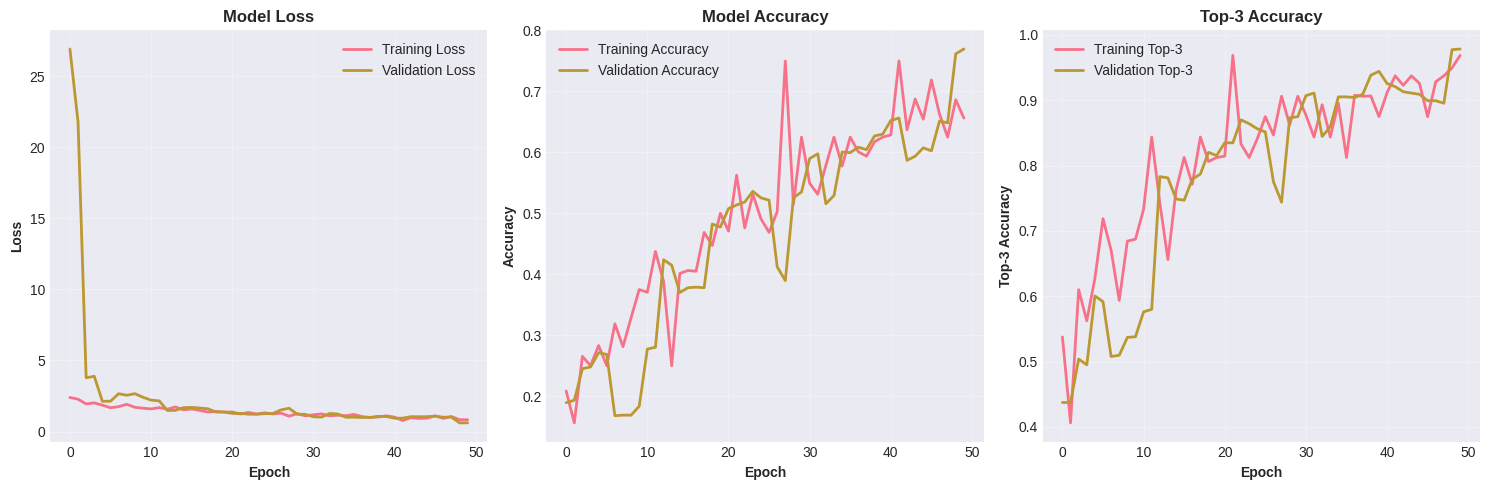


Final Training Metrics:
Training Loss: 0.8267
Validation Loss: 0.6138
Training Accuracy: 0.6562
Validation Accuracy: 0.7695
Training Top-3: 0.9688
Validation Top-3: 0.9785


In [38]:
def plot_training_history(history, figsize=(15, 5)):
    """
    Visualize training history: loss and accuracy curves
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Loss', fontweight='bold')
    axes[0].set_title('Model Loss', fontweight='bold', fontsize=12)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontweight='bold')
    axes[1].set_title('Model Accuracy', fontweight='bold', fontsize=12)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Top-3 Accuracy
    axes[2].plot(history.history['top_3_accuracy'], label='Training Top-3', linewidth=2)
    axes[2].plot(history.history['val_top_3_accuracy'], label='Validation Top-3', linewidth=2)
    axes[2].set_xlabel('Epoch', fontweight='bold')
    axes[2].set_ylabel('Top-3 Accuracy', fontweight='bold')
    axes[2].set_title('Top-3 Accuracy', fontweight='bold', fontsize=12)
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print("="*60)
    print(f"Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training Top-3: {history.history['top_3_accuracy'][-1]:.4f}")
    print(f"Validation Top-3: {history.history['val_top_3_accuracy'][-1]:.4f}")

plot_training_history(history)

## 12. Model Evaluation

In [39]:
# Evaluate on test set
print("Evaluating on test set...\n")

test_loss, test_accuracy, test_top3 = model.evaluate(test_gen, verbose=1)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-3 Accuracy: {test_top3:.4f} ({test_top3*100:.2f}%)")
print("="*60)

Evaluating on test set...

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.7601 - loss: 0.6538 - top_3_accuracy: 0.9702

TEST SET PERFORMANCE
Test Loss: 0.6490
Test Accuracy: 0.7515 (75.15%)
Test Top-3 Accuracy: 0.9748 (97.48%)


## 13. Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step


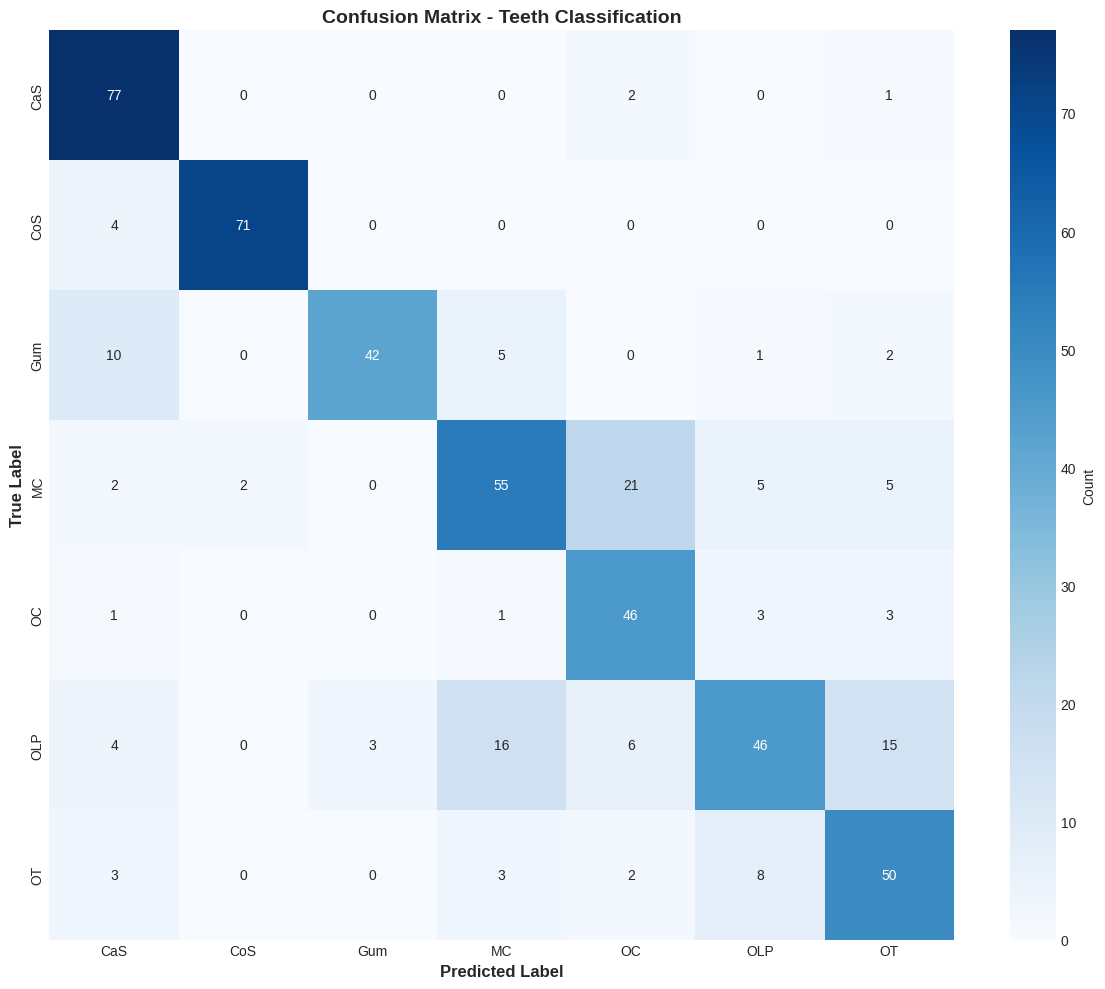

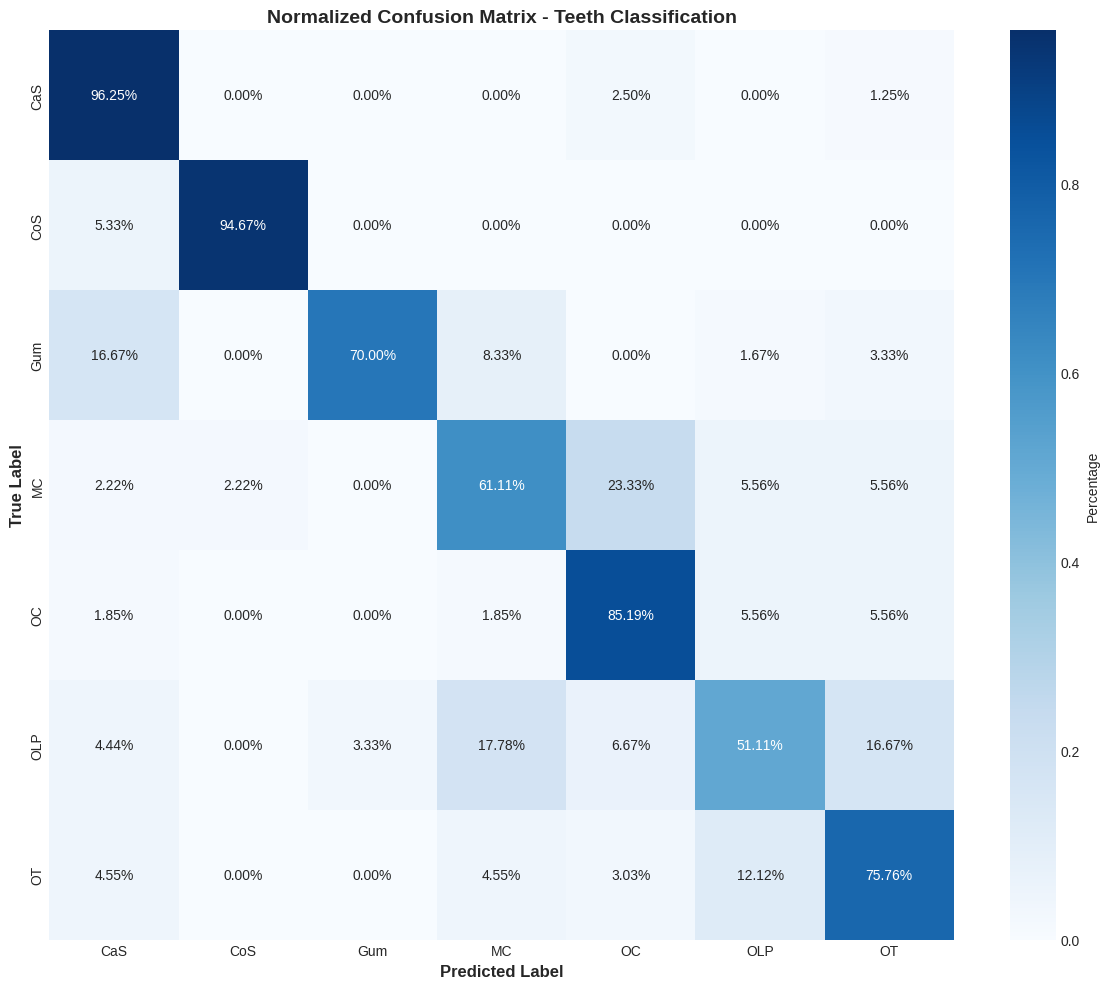

In [40]:
# Generate predictions
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Teeth Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix - Teeth Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Classification Report

In [41]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(report)

# Create detailed metrics DataFrame
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nDetailed Metrics per Class:")
print(metrics_df.to_string(index=False))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         CaS     0.7624    0.9625    0.8508        80
         CoS     0.9726    0.9467    0.9595        75
         Gum     0.9333    0.7000    0.8000        60
          MC     0.6875    0.6111    0.6471        90
          OC     0.5974    0.8519    0.7023        54
         OLP     0.7302    0.5111    0.6013        90
          OT     0.6579    0.7576    0.7042        66

    accuracy                         0.7515       515
   macro avg     0.7630    0.7630    0.7522       515
weighted avg     0.7635    0.7515    0.7471       515


Detailed Metrics per Class:
Class  Precision   Recall  F1-Score  Support
  CaS   0.762376 0.962500  0.850829       80
  CoS   0.972603 0.946667  0.959459       75
  Gum   0.933333 0.700000  0.800000       60
   MC   0.687500 0.611111  0.647059       90
   OC   0.597403 0.851852  0.702290       54
  OLP   0.730159 0.511111  0.601307       90
   OT   0.657895 0.757576  0.704225 

## 15. Per-Class Performance Visualization

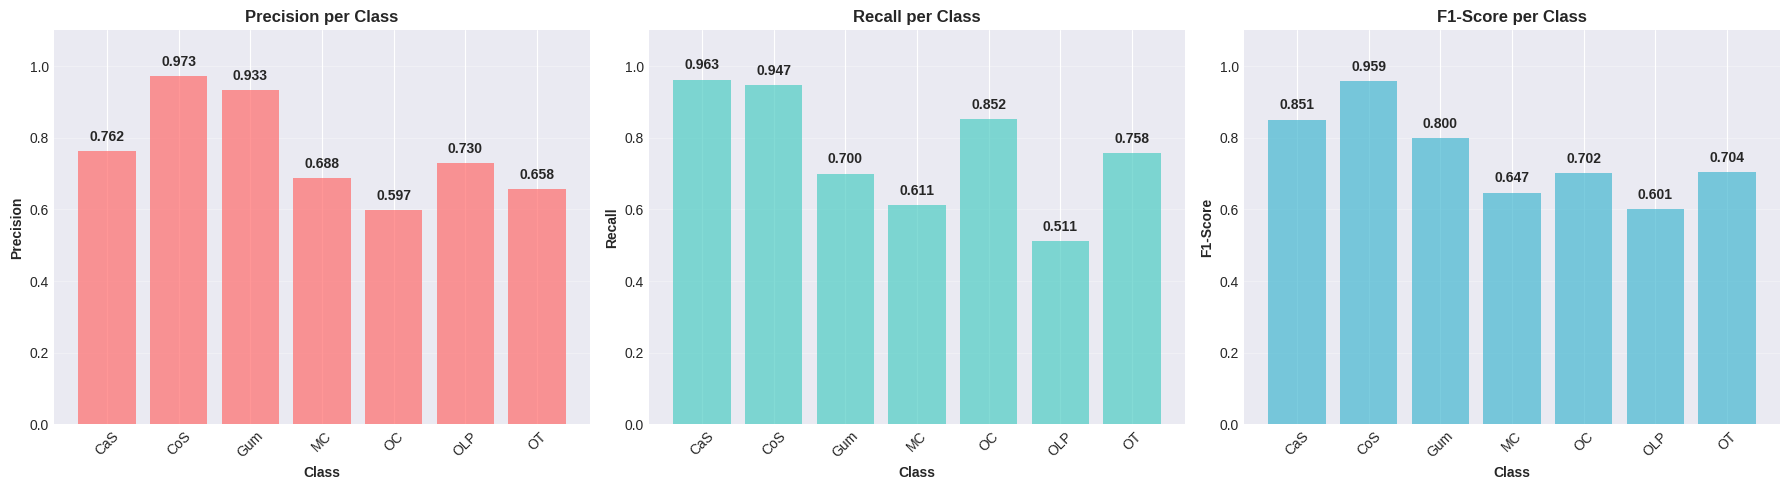

In [42]:
# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    axes[idx].bar(class_labels, metrics_df[metric], color=color, alpha=0.7)
    axes[idx].set_xlabel('Class', fontweight='bold')
    axes[idx].set_ylabel(metric, fontweight='bold')
    axes[idx].set_title(f'{metric} per Class', fontweight='bold', fontsize=12)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

    # Add value labels
    for i, v in enumerate(metrics_df[metric]):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 16. Sample Predictions Visualization

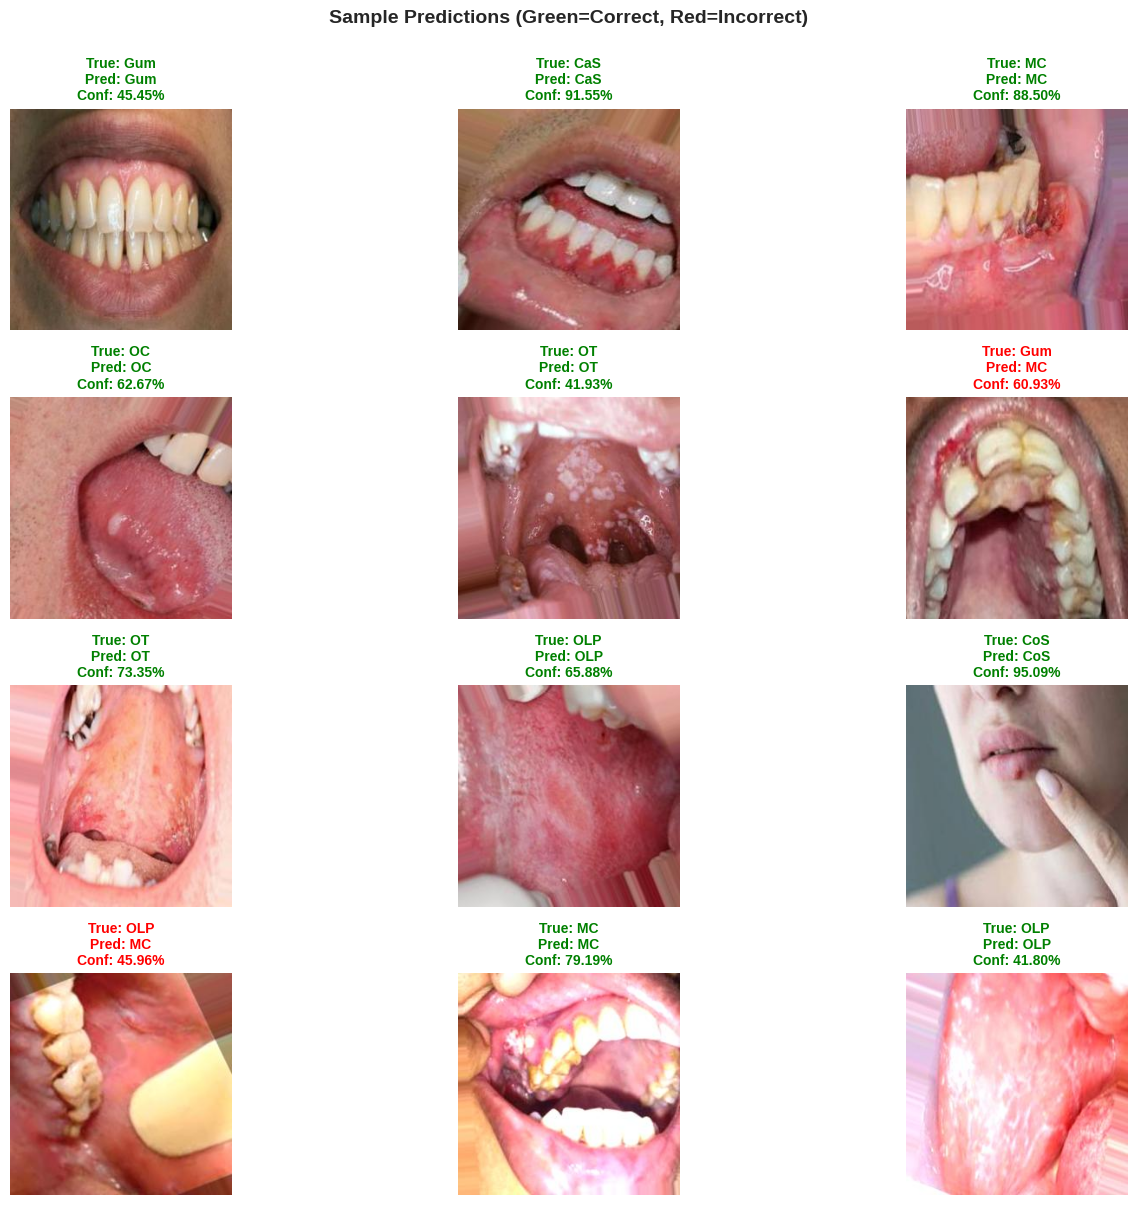

In [43]:
def visualize_predictions(model, test_df, n_samples=12, figsize=(15, 12)):
    """
    Visualize model predictions on random test samples
    """
    samples = test_df.sample(n_samples)

    rows = n_samples // 3
    fig, axes = plt.subplots(rows, 3, figsize=figsize)
    axes = axes.ravel()

    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load and preprocess image
        img = load_img(row['image_path'], target_size=config.IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        pred = model.predict(img_array, verbose=0)
        pred_class_idx = np.argmax(pred[0])
        pred_class = class_labels[pred_class_idx]
        confidence = pred[0][pred_class_idx]

        true_class = row['class']

        # Plot
        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Color based on correctness
        color = 'green' if pred_class == true_class else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2%}'
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_df)

## 18. Save Model and Artifacts

In [45]:
# Save model
model.save('teeth_classification_baseline.h5')
print("Model saved as 'teeth_classification_baseline.h5'")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved as 'training_history.csv'")

# Save class indices
import json
with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)
print("Class indices saved as 'class_indices.json'")

# Save predictions
pred_df = pd.DataFrame({
    'true_class': [class_labels[i] for i in y_true],
    'predicted_class': [class_labels[i] for i in y_pred],
    'correct': y_true == y_pred
})
pred_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved as 'test_predictions.csv'")

print("\n" + "="*80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("="*80)

Model saved as 'teeth_classification_baseline.h5'
Training history saved as 'training_history.csv'
Class indices saved as 'class_indices.json'
Test predictions saved as 'test_predictions.csv'

ALL ARTIFACTS SAVED SUCCESSFULLY


## 19. Future Improvements

### Recommended Next Steps:

1. **Transfer Learning**
   - Implement pre-trained models (ResNet, EfficientNet, VGG)
   - Fine-tune on teeth dataset
   - Compare with baseline performance

2. **Advanced Augmentation**
   - Implement Mixup/Cutmix
   - AutoAugment strategies
   - Test Time Augmentation (TTA)

3. **Ensemble Methods**
   - Train multiple models
   - Implement voting/averaging strategies
   - Boost overall accuracy

4. **Hyperparameter Optimization**
   - Learning rate scheduling
   - Architecture search
   - Regularization tuning

5. **Class Imbalance Handling**
   - Implement class weights
   - SMOTE or other sampling techniques
   - Focal loss implementation

6. **Explainability**
   - Grad-CAM visualization
   - Feature importance analysis
   - Model interpretability tools

---
